#  Машинный перевод с использованием рекуррентных нейронных сетей и механизма внимания

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#the-seq2seq-model
* https://www.adeveloperdiary.com/data-science/deep-learning/nlp/machine-translation-using-attention-with-pytorch/
* http://ethen8181.github.io/machine-learning/deep_learning/seq2seq/2_torch_seq2seq_attention.html
* https://tomekkorbak.com/2020/06/26/implementing-attention-in-pytorch/

## Задачи для совместного разбора

1\. Рассмотрите пример работы `torch.nn.utils.rnn.pad_sequence` для генерации батча.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch as th


class FakeDset(Dataset):
    def __init__(self):
        self.x = [
            th.LongTensor([2, 27, 705, 2327, 5744, 3]),
            th.LongTensor([2, 7, 29, 240, 5669, 2747, 1479, 3]),
            th.LongTensor([2, 27, 705, 2327, 3]),
            th.LongTensor([2, 7, 29, 240, 5669, 2747, 1479, 7, 29, 240, 5669, 3]),
        ]

    def __getitem__(self, idx):
        return (self.x[idx],)

    def __len__(self):
        return len(self.x)


In [ ]:
from torch.nn.utils.rnn import pad_sequence

In [ ]:
class Collator:
  def __init__(self, pad_idx, batch_first=True):
    self.pad_idx = pad_idx
    self.batch_first = batch_first

  def __call__(self, batch):
    x = [x[0] for x in batch]
    x = pad_sequence(x, batch_first=self.batch_first, padding_value=self.pad_idx)
    return x

In [ ]:
dset = FakeDset()
loader = DataLoader(dset, batch_size=2, collate_fn=Collator(pad_idx=0, batch_first=True))
next(iter(loader))

tensor([[   2,   27,  705, 2327, 5744,    3,    0,    0],
        [   2,    7,   29,  240, 5669, 2747, 1479,    3]])

2\. Рассмотрите основные шаги для реализации механизма аддитивного внимания с использованием RNN.

![attention](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS2F23YEOESycSImB4FBnFS09C_R18ffuD9luGO4X4cpF4Unqon5-l6fuWwsvottjU_Aj8&usqp=CAU)

$$c_i = \sum_{j=1}^{T_x}\alpha_{ij}h_j$$

$$\alpha_{ij} = \frac{exp(e_{ij})}{\sum_{j=1}^{T_x}exp(e_{ik})}$$

$$ e_{ij} = a(s_{i-1},h_j) = v_a^Ttanh(W_a s_{i-1} + U_a h_j)$$

In [ ]:
import torch.nn as nn
import torch as th

In [ ]:
batch_size, seq_len = 16, 5
enc_hidden_dim = 100
# x: batch x seq_len
# encoder(x)
encoder_out = th.rand(size=(batch_size, seq_len, enc_hidden_dim))
encoder_final_hidden = encoder_out[:, -1, :].unsqueeze(0)
# encoder_out: batch x  seq_len x enc_hidden_dim
# enc_final: 1 x bacth x enc_hidden_dim

In [ ]:
decoder_hidden_dim = 100
# без внимания
decoder_input = th.rand(batch_size, enc_hidden_dim)
decoder_hidden = encoder_final_hidden[0]
rnn = nn.GRUCell(enc_hidden_dim, decoder_hidden_dim)
rnn(decoder_input, decoder_hidden).shape

torch.Size([16, 100])

In [ ]:
decoder_hidden = encoder_final_hidden
decoder_hidden = decoder_hidden.repeat(seq_len, 1, 1).permute(1, 0, 2)
decoder_hidden.shape # batch x seq_len x encoder_hidden_dim

torch.Size([16, 5, 100])

In [ ]:
encoder_with_hidden = th.cat([decoder_hidden, encoder_out], dim=2)
encoder_with_hidden.shape

torch.Size([16, 5, 200])

In [ ]:
fc1 = nn.Linear(in_features=200, out_features=decoder_hidden_dim) # out_feat можно любой
attn_hidden = fc1(encoder_with_hidden).tanh()
# attn_hidden: bacth x seq_len x decoder_hid_dim

In [ ]:
fc2 = nn.Linear(in_features=decoder_hidden_dim, out_features=1)
energy = fc2(attn_hidden).squeeze()
# energy: batch x seq_len x 1
energy.shape

torch.Size([16, 5])

In [ ]:
attn = energy.softmax(dim=1)
attn

tensor([[0.1976, 0.1745, 0.2149, 0.1980, 0.2150],
        [0.1929, 0.1927, 0.2069, 0.2142, 0.1933],
        [0.2016, 0.2002, 0.1963, 0.1988, 0.2031],
        [0.1762, 0.2217, 0.2008, 0.1934, 0.2080],
        [0.2090, 0.1983, 0.2078, 0.1968, 0.1881],
        [0.1807, 0.1952, 0.2144, 0.2146, 0.1951],
        [0.1907, 0.2103, 0.2035, 0.1984, 0.1971],
        [0.1963, 0.1866, 0.1994, 0.2107, 0.2070],
        [0.1900, 0.1868, 0.1986, 0.2169, 0.2078],
        [0.1738, 0.1882, 0.2005, 0.2072, 0.2303],
        [0.2257, 0.1997, 0.2044, 0.1939, 0.1763],
        [0.2147, 0.2113, 0.1993, 0.1885, 0.1861],
        [0.2152, 0.1804, 0.2129, 0.1988, 0.1927],
        [0.1942, 0.2125, 0.2033, 0.1800, 0.2100],
        [0.2193, 0.1834, 0.1929, 0.2061, 0.1983],
        [0.1991, 0.2064, 0.1911, 0.1984, 0.2049]], grad_fn=<SoftmaxBackward0>)

In [ ]:
attn = attn.unsqueeze(1)
# attn: batch x 1 x seq_len
weigthted_encoder_out = th.bmm(attn, encoder_out).squeeze()
weigthted_encoder_out.shape

torch.Size([16, 100])

In [ ]:
rnn_input = th.cat([decoder_input, weigthted_encoder_out], dim=1)
rnn_input.shape

torch.Size([16, 200])

In [ ]:
decoder_hidden = encoder_final_hidden[0]
rnn = nn.GRUCell(200, decoder_hidden_dim)
rnn(rnn_input, decoder_hidden).shape # = decoder_hidden

torch.Size([16, 100])

## Задачи для самостоятельного решения

In [1]:
!pip install torchmetrics

In [2]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import torchtext.transforms as T
import torchmetrics as M
from torch.utils.data.dataloader import DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import json
import re

<p class="task" id="1"></p>

1\. Создайте наборы данных для решения задачи машинного перевода на основе файлов `RuBQ_2.0_train.json` (обучающее множество) и `RuBQ_2.0_test.json`. При подготовке набора данных не приводите весь набор данных к одинаковой фиксированной длине. Реализуйте класс `Collator`, который приводит все примеры в батче к одной фиксированной длине, используя `torch.nn.utils.rnn.pad_sequence`. Создайте `DataLoader` с использованием `collate_fn`, получите батч и выведите на экран размер тензоров.

- [x] Проверено на семинаре

In [3]:
X_train = []
y_train = []
X_test = []
y_test = []

with open('RuBQ_2.0_train.json', 'r') as f:
  for dct in json.load(f):
    X_train.append(re.sub(r'[^a-zа-я ]', '', dct['question_text'].lower()).split())
    y_train.append(re.sub(r'[^a-zа-я ]', '', dct['question_eng'].lower()).split())
with open('RuBQ_2.0_test.json', 'r') as f:
  for dct in json.load(f):
    X_test.append(re.sub(r'[^a-zа-я ]', '', dct['question_text'].lower()).split())
    y_test.append(re.sub(r'[^a-zа-я ]', '', dct['question_eng'].lower()).split())

In [4]:
ru_vocab = build_vocab_from_iterator(X_train, specials=['<PAD>', '<UNK>', '<SOS>', '<EOS>'])
en_vocab = build_vocab_from_iterator(y_train, specials=['<PAD>', '<UNK>', '<SOS>', '<EOS>'])
ru_vocab.set_default_index(ru_vocab['<UNK>'])
en_vocab.set_default_index(en_vocab['<UNK>'])
len(ru_vocab), len(en_vocab)

(5825, 4234)

In [5]:
class RuEnDataset:
  def __init__(self, ru_sents, en_sents, transforms):
    self.ru_sents = ru_sents
    self.en_sents = en_sents
    self.transform_ru = transforms[0]
    self.transform_en = transforms[1]

  def __getitem__(self, idx):
    return self.transform_ru(self.ru_sents[idx]), self.transform_en(self.en_sents[idx])

  def __len__(self):
    return len(self.ru_sents)

In [6]:
class Collator:
  def __init__(self, pad_idx, batch_first=True):
    self.pad_idx = pad_idx
    self.batch_first = batch_first

  def __call__(self, batch):
    x = [x[0] for x in batch]
    y = [y[1] for y in batch]
    x = pad_sequence(x, batch_first=self.batch_first, padding_value=self.pad_idx)
    y = pad_sequence(y, batch_first=self.batch_first, padding_value=self.pad_idx)
    return x, y

In [7]:
tr_ru = T.Sequential(
    T.AddToken('<SOS>'),
    T.AddToken('<EOS>', begin=False),
    T.VocabTransform(ru_vocab),
    T.ToTensor(0)
)
tr_en = T.Sequential(
    T.AddToken('<SOS>'),
    T.AddToken('<EOS>', begin=False),
    T.VocabTransform(en_vocab),
    T.ToTensor(0)
)
train_dataset = RuEnDataset(X_train, y_train, [tr_ru, tr_en])
test_dataset = RuEnDataset(X_test, y_test, [tr_ru, tr_en])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=Collator(0, batch_first=True))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=Collator(0, batch_first=True))

In [8]:
X, Y = next(iter(train_loader))
X.shape, Y.shape

(torch.Size([128, 17]), torch.Size([128, 25]))

<p class="task" id="2"></p>

2\. Создайте и обучите модель машинного перевода, используя архитектуру Encoder-Decoder на основе RNN с использованием механизма аддитивного внимания. Во время обучения выводите на экран значения функции потерь для эпохи (на обучающем множестве), значение accuracy по токенам (на обучающем множестве) и пример перевода, сгенерированного моделью. После завершения обучения посчитайте BLEU для тестового множества.

- [ ] Проверено на семинаре

In [22]:
class Encoder(nn.Module):
  def __init__(self, emb_dim, hidden_size, n_ru):
    super().__init__()
    self.emb = nn.Embedding(num_embeddings=n_ru, embedding_dim=emb_dim, padding_idx=0)
    self.drop = nn.Dropout(p=0.2)
    self.rnn = nn.GRU(emb_dim, hidden_size, batch_first=True)

  def forward(self, X):
    e = self.emb(X)
    out = self.drop(e)
    out, h = self.rnn(out)
    return out # batch x seq_len x hidden_size

class AttentionBlock(nn.Module):
  def __init__(self, enc_hid_dim):
    super().__init__()
    self.fc1 = nn.Linear(in_features=enc_hid_dim, out_features=100)
    self.fc2 = nn.Linear(in_features=100, out_features=1)

  def forward(self, encoder_with_hidden, encoder_out, decoder_input):
    out = self.fc1(encoder_with_hidden).tanh()
    energy = self.fc2(out).squeeze(2)
    attn = energy.softmax(dim=1).unsqueeze(1)
    weigthted_encoder_out = th.bmm(attn, encoder_out).squeeze(1)
    rnn_input = th.cat([decoder_input, weigthted_encoder_out], dim=1)
    return rnn_input, attn

class Decoder(nn.Module):
  def __init__(self, attention_block: AttentionBlock, emb_dim, hidden_size, n_en, DEVICE='cpu'):
    super().__init__()
    self.n_en_words = n_en
    self.emb = nn.Embedding(num_embeddings=n_en, embedding_dim=emb_dim, padding_idx=0)
    self.rnn = nn.GRUCell(emb_dim, hidden_size)
    self.attention = attention_block
    self.fc = nn.Linear(in_features=hidden_size, out_features=n_en)
    self.max_length = 0
    self.DEVICE = DEVICE

  def forward(self, encoder_out, labels=None, max_length=-1):
    batch_size = encoder_out.size(0)
    seq_len_enc = encoder_out.size(1)
    if labels is not None:
      seq_len = labels.size(1)
      self.max_length = max(max_length, self.max_length)
      input_tokens = labels[:, 0]
    else:
      seq_len = self.max_length
      input_tokens = th.empty(batch_size, dtype=th.long, device=self.DEVICE).fill_(2)

    enc_final_hidden = encoder_out[:, -1, :].unsqueeze(0)
    decoder_hidden = enc_final_hidden[0]
    decoder_out = [th.zeros(size=(batch_size, 1, self.n_en_words)).to(device=self.DEVICE)]
    self.attentions = []
    for i in range(1, seq_len):
      out = self.emb(input_tokens).relu() # batch x emb_dim

      hidden = enc_final_hidden.repeat(seq_len_enc, 1, 1).permute(1, 0, 2)
      encoder_with_hidden = th.cat([hidden, encoder_out], dim=2)
      rnn_input, attn = self.attention(encoder_with_hidden, encoder_out, decoder_hidden)

      decoder_hidden = self.rnn(rnn_input, decoder_hidden) # batch x dec_hidden
      out = self.fc(decoder_hidden) # batch x n_en
      decoder_out.append(out.unsqueeze(1))
      self.attentions.append(attn)

      if labels is not None:
        # teacher forcing
        input_tokens = labels[:, i]
      else:
        # without teacher forcing
        _, topi = out.topk(1)
        input_tokens = topi.squeeze(-1).detach()

    # batch x seq_len x n_en
    res = th.cat(decoder_out, dim=1)
    return res

class EncoderDecoder(nn.Module):
  def __init__(self, enc: Encoder, dec: Decoder):
    super().__init__()
    self.encoder = enc
    self.decoder = dec

  def forward(self, X, y=None):
    encoded = self.encoder(X)
    if y is not None:
      decoded = self.decoder(encoded, labels=y, max_length=y.size(1))
    else:
      decoded = self.decoder(encoded)
    decoded = decoded.reshape(-1, self.decoder.n_en_words)
    return decoded

In [23]:
n_epoch = 100
lr = 0.01
model = EncoderDecoder(
    Encoder(
        emb_dim=300,
        hidden_size=200,
        n_ru=len(ru_vocab)
    ),
    Decoder(
        attention_block=AttentionBlock(400),
        emb_dim=400,
        hidden_size=200,
        n_en=len(en_vocab),
        DEVICE='cuda'
    )
)
model.to(device='cuda')
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss(ignore_index=0)

for epoch in range(1, n_epoch+1):
  acc = M.Accuracy(task="multiclass", num_classes=len(en_vocab), ignore_index=0)
  for X_b, y_b in train_loader:
    out = model(X_b.to(device='cuda'), y_b.to(device='cuda'))
    loss = crit(out, th.flatten(y_b.to(device='cuda')))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    acc.update(out.to(device='cpu').argmax(dim=1).detach(), th.flatten(y_b))

  if epoch % 10 == 0:
    print(f'{epoch=} loss={loss.item():.5f} acc={acc.compute():.3f}')
    x_ex, y_ex = next(iter(train_loader))
    x_ex, y_ex = x_ex[0], y_ex[0]
    x_ex, y_ex = x_ex[x_ex > 0].unsqueeze(0), y_ex[y_ex > 0].unsqueeze(0)
    out = model(x_ex.to(device='cuda'))
    out = out.detach().to(device='cpu')
    out = out.argmax(dim=1)
    print(f'true rus:\t{" ".join(ru_vocab.lookup_tokens(x_ex.tolist()[0])[1:-1])}')
    print(f'true eng:\t{" ".join(en_vocab.lookup_tokens(y_ex.tolist()[0])[1:-1])}')
    print(f'predicted:\t{" ".join(en_vocab.lookup_tokens(out.tolist())[1:-1])}')

epoch=10 loss=4.20534 acc=0.361
true rus:	какая гора является высшей точкой польши
true eng:	which mountain is the highest point in poland
predicted:	which which is the the the the <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
epoch=20 loss=3.35259 acc=0.434
true rus:	какая твердость у золота
true eng:	what is the hardness of gold
predicted:	what is the the of of <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
epoch=30 loss=2.78453 acc=0.487
true rus:	где прошла коронация наполеона i
true eng:	where was the coronation of napoleon i
predicted:	where was the for i <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
epoch=40 loss=2.34245 acc=0.526
true rus:	когда убит троцкий
true eng:	when

In [ ]:
import nltk

In [ ]:
BLEU_scores = []
for X_b, y_b in test_loader:
  out = model(X_b.to(device='cuda'))
  out = out.detach().to(device='cpu')
  out = out.argmax(dim=1)

  y_b = th.flatten(y_b)
  out = th.flatten(out)
  not_pad_ind = (y_b > 0).nonzero(as_tuple=True)[0]
  y_b = y_b[not_pad_ind]
  out = out[not_pad_ind]
  hypothesis = y_b.tolist()
  reference = out.tolist()
  hypothesis = en_vocab.lookup_tokens(hypothesis)
  reference = en_vocab.lookup_tokens(reference)
  BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
  BLEU_scores.append(BLEUscore)
print(f'BLEU = {th.tensor(BLEU_scores).mean().item():.3f}')

BLEU = 0.132


<p class="task" id="3"></p>

3\. Сгенерируйте перевод при помощи обученной модели и визуализируйте матрицу внимания, в которой отображено, на какие слова из исходного предложения модель обращала внимание при генерации очередного слова в переводе.

- [ ] Проверено на семинаре

In [43]:
x, y = next(iter(train_loader))
x, y = x[0].unsqueeze(0), y[0].unsqueeze(0)
x.shape, y.shape

(torch.Size([1, 19]), torch.Size([1, 28]))

In [56]:
out = model(x.to(device='cuda'))
out = out.detach().to(device='cpu')
out = out.argmax(dim=1)
print(f'true rus:\t{" ".join(ru_vocab.lookup_tokens(x[x > 3].tolist()))}')
print(f'true eng:\t{" ".join(en_vocab.lookup_tokens(y[y > 3].tolist()))}')
print(f'predicted:\t{" ".join(en_vocab.lookup_tokens(out[out > 3].tolist()))}')

true rus:	кто написал картину девочка с персиками
true eng:	who painted the picture girl with peaches
predicted:	who painted the picture of the peaches


In [61]:
attn_lst = model.decoder.attentions
attn = th.cat(attn_lst, dim=1).squeeze().detach().cpu()
attn.shape

torch.Size([32, 19])

In [68]:
words_ru = ru_vocab.lookup_tokens(x[x > 3].tolist())
words_en = en_vocab.lookup_tokens(out[out > 3].tolist())

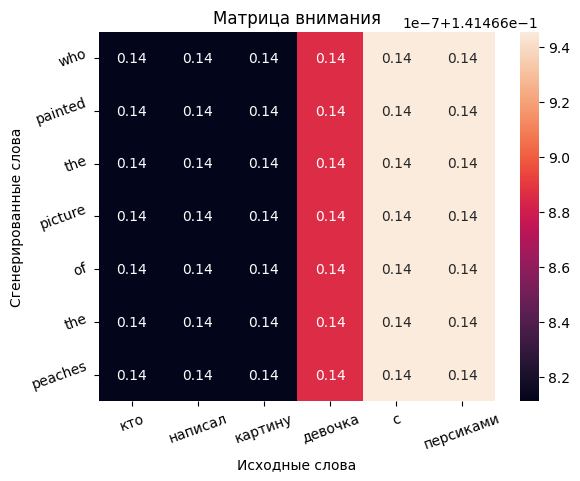

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(attn[1:len(words_en)+1, 1:len(words_ru)+1], annot=True)
plt.xlabel('Исходные слова')
plt.yticks(th.arange(0.5, len(words_en)+0.5), words_en, rotation=20)
plt.xticks(th.arange(0.5, len(words_ru)+0.5), words_ru, rotation=20)
plt.ylabel('Сгенерированные слова')
plt.title('Матрица внимания')
plt.show()

## Обратная связь
- [x] Хочу получить обратную связь по решению